<a href="https://colab.research.google.com/github/aachen6/deepTC/blob/master/colab/deepTC_classification_cnn5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepTC - CNN5

The overall objective of *deepTC* can be found on [deepTC github page](https://github.com/aachen6/deepTC/) for new readers. This notebook is where things start to get really fun and exicted, as everything will be linked together and put into the action. This notebook focus on implementation/training of a five-layer convolution network for TC intensity classification from satellite images based on the system we developed so far. 

1. Data Preprocess
   - 1.1 [Satellite images and tracks of TCs](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_sync.ipynb)

   - 1.2 [Statistics of satellite images and tracks](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_images_tracks_stats.ipynb)


2. Model for TC Image
   - 2.1 [Post-binding architecture of TC image](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_image.ipynb)

   - **2.2 [CNN model for intensity classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_cnn5.ipynb)**

   - 2.3 [Resnet model for intensity classification](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_classification_resnet.ipynb)

   - 2.4 [Resnet model for TC intensity estimation](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_intensity_resnet.ipynb)


3. Generversial Model for TC images
   - 3.1 [DCGAN model for deepTC](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_dcgan.ipynb)


4. Model for TC Track
   - 4.1 [Post-binding architecture of TC Track](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_net_track.ipynb)
    
   - 4.2 [LSTM model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstm.ipynb)
 
   - 4.3 [LSTM-CNN model for TC track prediction](https://github.com/aachen6/deepTC/blob/master/colab/deepTC_track_lstmcnn.ipynb)



Let's start with importing the necessary python modules. To reuse our previous notebook where the classes for the model, dataset, trainer, and inference have been defined, we install a package called *import-ipynb*, which loads the .ipynb into current notebook. Since the data is hosted on the Google Drive, we also mount my Google Drive and define some directories here. For new readers, you can find a copy of those datasets in [deepTC github page](https://github.com/aachen6/deepTC/).

In [0]:
!pip install import-ipynb

In [0]:
import os 
import yaml
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

work_dir = r'/content/drive/My Drive/Colab Notebooks/deepTC'
p_data  = work_dir + os.sep + 'data/AL'
p_image = work_dir + os.sep + 'image/AL'
p_model = work_dir + os.sep + 'model/tc_classification/cnn5'

# load class defined in other ipynb
import import_ipynb
model_ipynb = work_dir + os.sep + 'deepTC_net_image.ipynb'
with open(model_ipynb, 'rb') as fp:
    with open('deepTC_net_lib.ipynb','wb') as fout:
       fout.write(fp.read())
  
import deepTC_net_lib
from deepTC_net_lib import YML2Model, ImageDataSet, ImageTrainer, ImageInference


##CNN5

In a nutshell, the convolution network is a deep learning algorithm that applies multiple convolution operations (filters) to an input image with each being able to extract certain features (edge, texture, etc.) that are used collectively to differentiate the input image from others and generate specific output for it, see Figure below. The learning algorithm is the process to determine the best convolution operations that minimize the loss defined to measure the difference between the output and the target of images in the training set. To understand how and why this work, it helps to learn the convolution operation mathematically. The convolution operation moves a signal or function (filtering) along another signal or function (underlying) and performs the integration of the multiplication of the two while it's moving, which generates another signal or function, e.g. a step filtering function produces the average from portion of the underlying function that are covered by the step signal at a particular moment, therefore smooths the underlying function as it moves. By varying the filter function, different information from the underlying function can be obtained through the convolution. 

<img src='https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/assets/ezgif.com-optimize.gif'>*Image credit: Leonardoaraujosantos

For the convolution network, the filter generates feature maps, and the feature size is similar to the resolution, i.e. dimension of pixels. The number of filters at each layer is called filter depth or channels (similar to an image that has RGB channels).  The filter size or kernal size defines the portion of image (reception field) that is processed at a time during the convolution (similar to step function size in the example above), which may move at different stride, i.e. pixels the filter slides. Zero padding can be used to maintain the feature size.  


###Network Architecture
The overall network architecture and training parameters are defined in the configuration file. Specifically, it simply defines a sequential five-layer convolution network (*CNN5 net*) as shown in Figure below. The input images are greyscale with only one channel. The first layer increases the channel size to 32 with a 5 x 5 filter and reduces the feature size by a factor of four using *maxpool2d* function with stride of 2. In each of the following layer, the channel size is doubled with a 3 x 3 filter while the feature size is quartered using *maxpool2d* with stride of 2 in each layer as shown in the callout box. *ReLU* activation function is used for each layer. The features are then flattened and transformed into a vector of 7 corresponding to the number of classes. 
 
<img src='https://raw.githubusercontent.com/aachen6/deepTC/master/model/tc_classification/cnn5/cnn5.png' width='800'/>

The dataset is firstly split randomly into 90% of training and 10% testing, where the 90% training data is further split randomly into 80% of training and 20% of validation with a final separation ratio of 72:18:10 as shown in the log. The ratio of number of samples for each class is preserved during the split. Since this is a multi-class classification problem, we used *Cross-Entropy* loss with *Adam* optimizer wi The default learning rate &eta;=0.001 and momentum parameters (&beta;<sub>1</sub>=0.9, &beta;<sub>2</sub>=0.999) are used. 

We trained the model for 15 epochs with a batch size of 64. The loss and accuracy of each batch and epoch (running average) are generated and updated in the plot below during the training and validation process. The model converges very rapidly reaching a validation accuracy of 95% only after 4 epochs. Since validation is performed after training, it presents lower loss and higher accuracy than that from training at the beginning. While the loss decreases and the accuracy increases, they become larger and less than that from training, respectively, indicating the training is saturated. The model achieved a final validation accuary of 98.1% after 15 epochs.

###Training and Validation

In [0]:
import torch
from torchvision.transforms import transforms

torch.cuda.empty_cache()

# load configuration file
f_config = p_model + os.sep + 'config_cnn5.yaml'
with open(f_config, 'r') as fp: config = yaml.load(fp)

# contruct the model
storm_cnn = YML2Model(config, 'cnn5')

# update path for config
config_params = config['params']
config_params['f_image_zip'] = p_image + os.sep + config_params['f_image_zip']
config_params['f_storm_msg'] = p_data  + os.sep + config_params['f_storm_msg']
config_params['f_state_yml'] = p_model + os.sep + config_params['f_state_yml']
config_params['f_model_pth'] = p_model + os.sep + config_params['f_model_pth']
config_params['f_test_yml']  = p_model + os.sep + config_params['f_test_yml']

# splitted data to be used in other model as well for comparison
config_params['f_data_yml']  = work_dir + os.sep + 'model/classification' +
                               os.sep + config_params['f_data_yml']

# normalization is based on ramdon 1000 samples for this test
image_transforms = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.456,), (0.222,))])

# dataset
storm_data = ImageDataSet(config_params, image_transforms, hotstart=False)
data_split = storm_data.load_data()

# model
storm_train = ImageTrainer(config_params, storm_cnn, hotstart=False)

# train & valid
storm_train.train_loop(data_split)

# test
test_results = storm_train.test_loop(data_split)


------------------------------------
summary of dataset
------------------------------------
               train     valid      test
percent         0.72      0.18      0.10
size           34944      8742      4857
batch            546       136        75
------------------------------------
summary of GPU
------------------------------------
Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
------------------------------------
training
------------------------------------


------------------------------------
summary of epoch: 0
------------------------------------
                loss  accurary
train          1.113    57.698
valid          0.758    72.235
 


------------------------------------
summary of epoch: 1
------------------------------------
                loss  accurary
train          0.553    80.122
valid          0.377    86.841
 


------------------------------------
summary of epoch: 2
------------------------------------
                loss  accurary
train          0.289    90.179
valid          0.217    92.746
 


------------------------------------
summary of epoch: 3
------------------------------------
                loss  accurary
train          0.187    93.716
valid          0.138    95.532
 


------------------------------------
summary of epoch: 4
------------------------------------
                loss  accurary
train          0.131    95.682
valid          0.097    96.909
 


------------------------------------
summary of epoch: 5
------------------------------------
                loss  accurary
train          0.101    96.557
valid          0.096    96.898
 


------------------------------------
summary of epoch: 6
------------------------------------
                loss  accurary
train          0.083    97.115
valid          0.089    97.087
 


------------------------------------
summary of epoch: 7
------------------------------------
                loss  accurary
train          0.075    97.530
valid          0.067    97.890
 


------------------------------------
summary of epoch: 8
------------------------------------
                loss  accurary
train          0.057    98.131
valid          0.073    97.631
 


------------------------------------
summary of epoch: 9
------------------------------------
                loss  accurary
train          0.060    97.957
valid          0.058    98.049
 


------------------------------------
summary of epoch: 10
------------------------------------
                loss  accurary
train          0.061    97.940
valid          0.053    98.293
 


------------------------------------
summary of epoch: 11
------------------------------------
                loss  accurary
train          0.045    98.440
valid          0.058    98.061
 


------------------------------------
summary of epoch: 12
------------------------------------
                loss  accurary
train          0.042    98.581
valid          0.062    98.152
 


------------------------------------
summary of epoch: 13
------------------------------------
                loss  accurary
train          0.041    98.655
valid          0.059    98.198
 


------------------------------------
summary of epoch: 14
------------------------------------
                loss  accurary
train          0.039    98.729
valid          0.059    98.130
 
------------------------------------
summary of test
------------------------------------
               total  accuracy
test            4857    95.000


###Test Performance

Let's now take a look at the model performance on the test dataset. The overall test accuracy is 95.7%. However, the analysis in [Statistics of satellite images and tracks](https://) shows that the number of sample for each class is not well balanced, the class with a few samples maybe heavilty biased without hurting the overal accuracy. To verify that, let's look at the confusion matrix. Surprisingly, the confusion matrix shows that the model perform well for classes with less samples, indicating the model is not sensitive to such imbalance in the sample classes. To ensure the best practices, we can penalize the loss based on the sample size ratio of each class. Next, we will turn our attention to residual network to see if we can further improve the accuracy of the prediction.

------------------------------------
summary of test
------------------------------------
               total  accuracy
test            4857    95.718


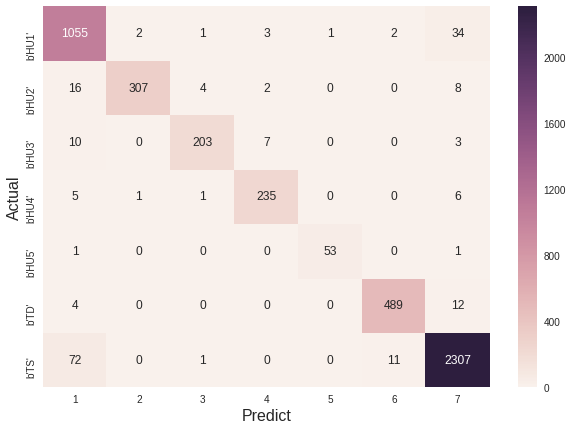

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# CONSTANT
f_data_yml = config_params['f_data_yml']
with open(f_data_yml, 'rb') as fp: data = yaml.load(fp)
    
one_hot_key   = data['one_hot_key']
one_hot_rev   = data['one_hot_rev']
train_indices = data['indices']['train']
valid_indices = data['indices']['valid']
test_indices  = data['indices']['test']

f_test = config_params['f_test_yml']
with open(f_test, 'r') as fp: test_results = yaml.load(fp)
test_idxs = test_results['idxs']
#test_idxs = test_idxs.detach().numpy()
test_labels = test_results['labels']
test_predicts = test_results['predicts']
   
# check test data, for debug purpose to make sure test dataset is correct
# f_img_msg = p_data + os.sep + 'al_ir_track_filtered.msg'
# pd_storm = pd.read_msgpack(f_img_msg) 
# print(len(test_labels))
# print(len(pd_storm.iloc[test_indices].index))
# print(pd_storm.iloc[test_indices].groupby(b'cat').count())
# print(np.unique(test_labels, return_counts=True))

# test summary
n_correct = np.equal(test_predicts, test_labels).sum().item()
accuracy = n_correct / len(test_labels) * 100.
divider = '-' * 36
print(divider)
print('summary of test')
print(divider)
print('{:<10s}{:>10s}{:>10s}'.format('', 'total', 'accuracy'))
print('{:<10s}{:>10d}{:>10.3f}'.format('test', len(test_labels), accuracy))   

# confusion matrix
cfx = confusion_matrix(test_labels, test_predicts)
df_cfx = pd.DataFrame(cfx, index = [one_hot_rev[i] for i in range(7)], 
                           columns = [str(i+1) for i in range(7)])

fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(df_cfx, annot=True, annot_kws={'size': 12}, fmt='d', ax=ax)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('Actual',fontsize=16)

# true_to_false
true_to_false = {} # miss-classified images
for i in range(7): true_to_false[one_hot_rev[i]] = []
for i, (x, y) in enumerate(zip(test_labels, test_predicts)):
    if x==y: continue
    true_cat = one_hot_rev[x]
    false_cat = one_hot_rev[y]
    true_to_false[true_cat].append([test_idxs[i], false_cat])
    